<img style="float:left" src="julialogo-smaller.png"/>

<br>
   * innovative open-source scientific programming language
   * **easy as Matlab, fast as Fortran, flexible as Python, deep as LISP**
   * leverages major C/Fortran science packages, e.g. LAPACK, MPI, FFTW... 
   * 5th language to run at 1 petaflops, after assembly, Fortran, C, C++ 
   * solves the "two-language problem"
   * the future of scientific computing!
   
-- talk by John Gibson, Mathematics & Statistics, U New Hampshire

<br> 

# Background


  * origins at MIT, UCSB applied math & computer science, 2010 
    
  * founders Viral Shah, Jeff Bezanson, Stefan Karpinsky (now at Julia Computing LLC), Alan Edelman (MIT)
        
  * ~10-person core language team, ~600 contributors, ~1000 registered packages 
    
  * support from Intel, Microsoft, Wall St., Moore Foundation, NumFocus
   
  * julia-0.1 released 2012, julia-0.6 2017, julia-1.0 target August 2018
  <br> <br> <br> <br> <br>

# Julia: easy as Matlab

Julia is a drop-in replacement for Matlab for interactive calculations with built-in numerical libraries and plotting. A few examples...

### Linear algebra 

In [2]:
A = randn(4,4)

4×4 Array{Float64,2}:
 -0.556563   -0.322254    -1.00336   -0.117617
 -0.596044    1.50983      0.138714  -1.15817 
  0.322196   -0.213154    -0.939591  -1.0961  
 -0.0500368  -0.00034636  -0.662983  -0.283092

In [3]:
A[:,1]                # familiar colon syntax

4-element Array{Float64,1}:
 -0.556563 
 -0.596044 
  0.322196 
 -0.0500368

In [4]:
b = randn(4)          
x = A\b               # solve Ax=b for x using backslash operator
norm(A*x-b)

3.084219802941567e-16

In [5]:
U, Σ, V = svd(A);     # unicode variable name Σ
Σ

4-element Array{Float64,1}:
 2.07779 
 1.76311 
 0.856009
 0.163666

### Numerical integration of differential equation

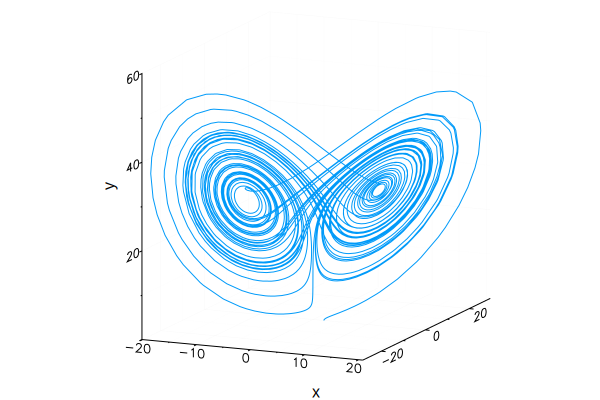

In [7]:
# define Lorenz dynamics dx/dt = lorenz(t,x)
function lorenz(t, x)
    σ = 10
    β = 8/3
    ρ = 28
    [σ*(x[2]-x[1]); x[1]*(ρ-x[3]); x[1]*x[2] - β*x[3]]
end

# integratedx/dt = lorenz(t,x) numerically from t=0 to t=50
tspan = 0:0.02:50.0
x₀ = [2.0; 0.0; 0.0]
t,x = ode45(lorenz, x₀, tspan)
y = x
x = hcat(x...)';

# plot Lorenz attractor
plot(x[:,1], x[:,2], x[:,3], l=:path3d, xlab="x", ylab="y", zlab="z", label="")

### Don't try this in Matlab...

In [8]:
⊕ = (x,y) -> 3x + 2y       # define ⊕ operator (unicode program text)

@show 5 ⊕ 1;   println()   # apply ⊕ to two Int64s

@show 2//5 ⊕ (3 - 7im);    # Rational{Int64} ⊕ Complex{Int64} produces Complex{Rational{Int64}

5 ⊕ 1 = 17

2 // 5 ⊕ (3 - 7im) = 36//5 - 14//1*im


<br> <br> <br> <br> <br>


# Julia: fast as Fortran

But unlike Matlab, Julia runs as fast as Fortran. A demo on a nonlinear PDE:

### Kuramoto-Sivashinsky equation

The Kuramoto-Sivashinsky (KS) equation is a nonlinear time-evolving partial differential equation (PDE) on a 1d spatial domain.

\begin{equation*}
u_t = - u_{xx} - u_{xxxx} - u u_x
\end{equation*}

where $x$ is space, $t$ is time, and subscripts indicate differentiation. We assume a spatial domain $x \in [0, L_x]$ with periodic boundary conditions and initial condition $u(x,0) = u_0(x)$.

<img style="float:center" src="ksdynamics.svg"/>


### Numerical integration algorithm: KS-CNAB2

Represent the linear terms as $Lu = (-D^2 -D^4)\, u$ and the nonlinear term as $N(u) = 1/2\, D \,u^2$ where $D = \partial/\partial x$.

\begin{equation*}
u_t = Lu + N(u)
\end{equation*}

Discretize time by letting $u^n(x) = u(x, n\Delta t)$ for some small $\Delta t$, and use Crank-Nicolson, Adams-Bashforth (CNAB2) timestepping. 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = L\left(\frac{u^{n+1} + u^n}{2} \right) + \frac{3}{2} N(u^n) - \frac{1}{2} N(u^{n-1})
\end{equation*}


Put the unknowns (future) $u^{n+1}$'s on the LHS and knowns (past) $u^{n}$ and past $u^{n+1}$ on the RHS.

\begin{equation*}
\left(I  - \frac{\Delta t}{2} L \right) u^{n+1} = \left(I  + \frac{\Delta t}{2}L \right) u^{n} + \frac{3 \Delta t}{2} N(u^n) - \frac{\Delta t}{2} N(u^{n-1})
\end{equation*}

Discretize space with a finite Fourier transform, so that $(I  \mp \Delta t/2 \, L)$ becomes diagonal matrices $A$ and $B$, and $N^n$ is the Fourier transform of $N(u^n)$.

\begin{equation*}
A \, u^{n+1} = B \, u^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}
\end{equation*}

This is an $Ax=b$ problem whose iteration approximates the time-evolution of the Kuramoto-Sivashinksy PDE. 

### Julia code for KS-CNAB2 algorithm

In [9]:
function ksintegrate(u₀, Lₓ, Δt, Nsteps, nsave);
    uⁿ = (1+0im)*u₀                      # force u to be complex
    Nₓ = length(uⁿ)                       # number of gridpoints
    kₓ = vcat(0:Nₓ/2-1, 0:0, -Nₓ/2+1:-1)  # integer wavenumbers: exp(2πikₓ x/L)
    α  = 2*pi*kₓ/Lₓ                       # real wavenumbers:    exp(iαx)
    D  = 1im*α                           # spectral D = d/dx operator 
    L  = α.^2 - α.^4                     # spectral L = -D^2 - D^4 operator
    G  = -0.5*D                          # spectral -1/2 D operator
    
    Nsave = div(Nsteps, nsave)+1         # number of saved u's, including t=0
    t = (0:Nsave)*(Δt*nsave)             # times of saved u's
    U = zeros(Nsave, Nₓ)                 # matrix of u(tᵢ, xⱼ) values
    U[1,:] = real(u₀)                    # assign initial condition to U
    s = 2                                # counter for saved data
    
    # construct diagonal matrices for LHS and RHS linear operators
    I   = ones(Nₓ)
    A⁻¹ = (I - Δt/2*L).^(-1)             
    B   = I + Δt/2*L
    
    # compute in-place FFTW plans
    FFT!  = plan_fft!(uⁿ,  flags=FFTW.ESTIMATE)
    IFFT! = plan_ifft!(uⁿ, flags=FFTW.ESTIMATE)

    # initialize nonlinear terms 
    Nuⁿ  = G.*fft(uⁿ.^2)      # set Nuⁿ = -1/2 d/dx (uⁿ)² = -u uₓ 
    Nuⁿ⁻¹ = copy(Nuⁿ)         # set Nuⁿ⁻¹ = Nuⁿ for first time step
    FFT!*uⁿ
    
    # timestepping loop
    for n = 1:Nsteps
        
        Nuⁿ⁻¹ .= Nuⁿ        # shift nonlinear term in time
        Nuⁿ  .= uⁿ         # store uⁿ in Nuⁿ in prep for collocation computation
        
        IFFT!*Nuⁿ          # transform to gridpt values of u
        Nuⁿ .= Nuⁿ.*Nuⁿ    # collocation calculation of u²
        FFT!*Nuⁿ           # transform u² back to spectral coeffs

        Nuⁿ .= G.*Nuⁿ      # compute  Nuⁿ = -1/2 d/dx u² = -u uₓ

        # Loop fusion! Julia unrolls this line into a single for-loop over vector elems,
        # avoiding the generation and allocation of temporary vectors you'd get in Matlab
        uⁿ .= A⁻¹ .* (B .* uⁿ .+ 3Δt/2.*Nuⁿ .- Δt/2.*Nuⁿ⁻¹)
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(uⁿ))  # save into return matrix U 
            s += 1            
        end
    end
   
    t,U
end

ksintegrate (generic function with 1 method)

### Execute Julia KS-CNAB2 code

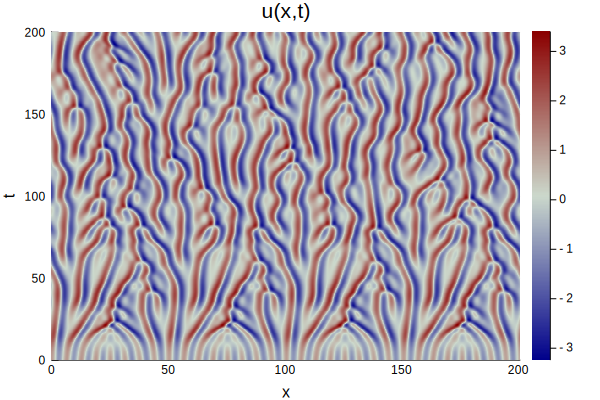

In [11]:
# set discretization parameters
Lx = 64π
Nx = 1024
Δt = 1/16
nsave = 8
Nsteps = 3200

# set initial condition
x = Lx*(0:Nx-1)/Nx
u₀ = cos.(x) + 0.1*sin.(x/8) + 0.001*cos.(x/32);

# integrate PDE
t,U = ksintegrate(u₀, Lx, Δt, Nsteps, nsave) 

# plot results
heatmap(x,t, U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), xlabel="x", ylabel="t", title="u(x,t)", fillcolor=:bluesreds)

### KS-CNAB2 benchmark: CPU time versus gridsize

Identical algorithm in six languages

<img style="float:left" src="ks_cpu_scaling.svg"/>

### KS-CNAB2 benchmark: CPU time versus lines of code 

For the moderate-sized computational domain shown above, $L_x = 64\pi,\; N_x = 1024$.
<img style="float:left" src="ks_cpu_vs_lines_1024.svg"/>


### Benchmarks on common code pattterns

<img style="float:left" src="benchmarks.svg"/>

<br> <br> <br>

# Julia: easy, dynamic, and fast. How? 


 * **Just-in-time compilation** (JIT)
    - user-level code is compiled to machine code on-the-fly  
    
    
 * **Meticulous type system**
    - designed to maximize impact of JIT
    - type inference: compiler determines types of variables
    
    
 * **Multiple dispatch**
    - functions are compiled for each set of argument types
    - function dispatch determined at compile time when possible, run time when not
 
 
 <br> <br>

### Just-in-time compilation

Functions are compiled to machine code when first run. Subsequent runs are as fast as compiled C, C++, Fortran.

#### Logistic map example $f(x) = 4\, x\, (1-x)$.


In [12]:
f(x) = 4x*(1-x)     # define logistic map
@time f(0.3);       # first run is slow
@time f(0.4);       # second run is a thousand times faster

  0.002265 seconds (497 allocations: 29.339 KiB)
  0.000001 seconds (5 allocations: 176 bytes)


#### Observe the compilation of $f(x)$ by stages

user Julia -> generic Julia expression -> typed Julia expression -> intermediate compiler language -> machine code

In [13]:
@code_lowered f(0.3)  # show f(x) as generic Julia expression

CodeInfo(:(begin 
        nothing
        return (4 * x) * (1 - x)
    end))

In [14]:
@code_typed f(0.3)    # show f(x) as Julia expression with inferred types, based on the argument types

CodeInfo(:(begin 
        return (Base.mul_float)((Base.mul_float)((Base.sitofp)(Float64, 4)::Float64, x)::Float64, (Base.sub_float)((Base.sitofp)(Float64, 1)::Float64, x)::Float64)::Float64
    end))=>Float64

In [15]:
@code_llvm f(0.3)    # show f(x) in intermediate compiler language (LLVM)


define double @julia_f_64648(double) #0 !dbg !5 {
top:
  %1 = fmul double %0, 4.000000e+00
  %2 = fsub double 1.000000e+00, %0
  %3 = fmul double %1, %2
  ret double %3
}


In [16]:
@code_native f(0.3) # show f(x) in IA-64 assembly language

	.text
Filename: In[12]
	pushq	%rbp
	movq	%rsp, %rbp
	movabsq	$140432395624992, %rax  # imm = 0x7FB8F70E6220
	movabsq	$140432395625000, %rcx  # imm = 0x7FB8F70E6228
Source line: 1
	movsd	(%rcx), %xmm1           # xmm1 = mem[0],zero
	subsd	%xmm0, %xmm1
	mulsd	(%rax), %xmm0
	mulsd	%xmm1, %xmm0
	popq	%rbp
	retq
	nopw	(%rax,%rax)


### Millionth iterate of logistic map: comparison of Julia, C, Matlab

Given $f(x) = 4\,x \, (1-x)$, 

let $~~f^N(x) = f(\,f(\,...(\,f(\,f(x)))))$ be the millionth iterate of $f$, with $N=10^6$.

#### $f^N$ in Julia: run-time code generation & compilation!

In [17]:
# define function that, given function g(x), returns iterated function gᴺ(x) = g(g(...(g(g(x)))))
function iterator(g, N)
    
    # construct gᴺ, the Nth iterate of g
    function gᴺ(x)
       for i ∈ 1:N             
          x = g(x)
       end        
       return x
    end    
    
    return gᴺ
end


fᴺ = iterator(f, 10^6);  # generate millionth iterate funcion fᴺ(x) for f(x) = 4x(1-x)

fᴺ(0.67)                 # run fᴺ(x) once to compile it

0.10116885334547539

#### $f^N$ in C++, compiled

In [18]:
; cat fN.cpp

#include <stdlib.h>
#include <iostream>
#include <iomanip>
#include <ctime>

using namespace std;

inline double f(double x) {
  return 4*x*(1-x);
}

int main(int argc, char* argv[]) {
  double x = argc > 1 ? atof(argv[1]) : 0.0;

  double t0 = clock();
  for (int n=0; n<1000000; ++n)
    x = f(x);
  double t1 = clock();

  cout << "t = " << (t1-t0)/CLOCKS_PER_SEC << " seconds" << endl;
  cout << setprecision(17);
  cout << "x = " << x << endl;
  
  return 0;
}
  


 Compile fN.cpp in Unix shell

In [19]:
; g++ -O3 -o fN fN.cpp -lm 

### Compare execution time of $f^N$ in Julia, C++, Matlab

#### Julia

In [20]:
print("t=");
@time x = fᴺ(0.67);         # run the Julia fᴺ on x = 0.67
@show x;

t=  0.002504 seconds (5 allocations: 176 bytes)
x = 0.10116885334547539


#### C++

In [21]:
; fN 0.67 

t = 0.002947 seconds
x = 0.10116885334547539


Julia and C++ get the same result `x` in roughly same execution time `t`. Sometimes Julia is faster, sometimes C++.

#### Matlab
```
>> tic(); x=fN(0.67); t=toc();
>> t, x
t = 0.048889000000000
x = 0.101168853345475
```
Matlab gets the same result $x$, but ten to twenty times slower than Julia or C++.

## Type inference

Julia reasons about types and infers types of variables from context, enabling compilation to hardware instructions. 

Language and type system carefully designed maximize effectiveness of just-in-time compilation. Matlab, Python syntax precludes this.

### Type inference on $f(x)$

In [22]:
# recall definition of f(x): no types are mentioned!
f(x) = 4x*(1-x)

f (generic function with 1 method)

In [23]:
@code_llvm f(0.3)   # intermediate compiler code for f applied to Float64 argument


define double @julia_f_64824(double) #0 !dbg !5 {
top:
  %1 = fmul double %0, 4.000000e+00
  %2 = fsub double 1.000000e+00, %0
  %3 = fmul double %1, %2
  ret double %3
}


In [24]:
@code_llvm f(2)     # intermediate compiler code for f applied to Int64 argument


define i64 @julia_f_64826(i64) #0 !dbg !5 {
top:
  %1 = shl i64 %0, 2
  %2 = sub i64 1, %0
  %3 = mul i64 %1, %2
  ret i64 %3
}


### Type inference on $f^N(x)$

No types are specified in the definition of th ieterated function $f^N(x)$, but the compiler figures out that the loop index $i$ is an integer, and that arithmetic temporaries are Float64.

In [25]:
# Recall definition of fᴺ
function iterator(g, N)
    
    # construct gᴺ, the Nth iterate of g
    function gᴺ(x)
       for i ∈ 1:N             
          x = g(x)
       end        
       return x
    end    
    
    return gᴺ
end

fᴺ = iterator(f, 10^6);  # generate million iterate function fᴺ(x) for f(x) = 4x(1-x)

@code_llvm fᴺ(0.67)      # show intermediate compiler code for fᴺ applied to Float64 argument


define double @"julia_g\E1\B4\BA_64828"(%"#g\E1\B4\BA#16"* nocapture readonly dereferenceable(8), double) #0 !dbg !5 {
top:
  %2 = getelementptr inbounds %"#g\E1\B4\BA#16", %"#g\E1\B4\BA#16"* %0, i64 0, i32 1
  %3 = load i64, i64* %2, align 8
  %4 = icmp slt i64 %3, 1
  br i1 %4, label %L14, label %if.preheader

if.preheader:                                     ; preds = %top
  br label %if

if:                                               ; preds = %if.preheader, %if
  %x.03 = phi double [ %8, %if ], [ %1, %if.preheader ]
  %"#temp#.02" = phi i64 [ %5, %if ], [ 1, %if.preheader ]
  %5 = add i64 %"#temp#.02", 1
  %6 = fmul double %x.03, 4.000000e+00
  %7 = fsub double 1.000000e+00, %x.03
  %8 = fmul double %6, %7
  %9 = icmp eq i64 %"#temp#.02", %3
  br i1 %9, label %L14.loopexit, label %if

L14.loopexit:                                     ; preds = %if
  br label %L14

L14:                                              ; preds = %L14.loopexit, %top
  %x.0.lcssa = phi double [ %1, %t

<br> <br> <br> <br>

# Julia: flexible as Python


### Comprehensive numeric type system

In [27]:
# define a set of various numeric types
X = (1, 0.5f0, 0.5, 2//3, 2+3im, 2.1 + 4.3im, 2//3 + 4//5im, BigFloat(2//3), BigFloat(2//3) + BigFloat(4//5)*im);

# loop over elements of X, print type and compute value of logistic map f(x)
for x ∈ X
    println("typeof(x) = $(typeof(x)), f(x) = $(f(x))\n")
end

typeof(x) = Int64, f(x) = 0

typeof(x) = Float32, f(x) = 1.0

typeof(x) = Float64, f(x) = 1.0

typeof(x) = Rational{Int64}, f(x) = 8//9

typeof(x) = Complex{Int64}, f(x) = 28 - 36im

typeof(x) = Complex{Float64}, f(x) = 64.72 - 55.04im

typeof(x) = Complex{Rational{Int64}}, f(x) = 776//225 + 16//15*im

typeof(x) = BigFloat, f(x) = 8.88888888888888888888888888888888888888888888888888888888888888888888888888887e-01

typeof(x) = Complex{BigFloat}, f(x) = 3.448888888888888888888888888888888888888888888888888888888888888888888888888868 - 1.066666666666666666666666666666666666666666666666666666666666666666666666666692im



In [28]:
# exact arithmetic: compute 7th iterate of logisitic map on Rational{BigInt}
f⁷ = iterator(f, 7)
@show x = f⁷(big(2//3));

x = f⁷(big(2 // 3)) = 674838593766753484487654913831820720085359667709963001167872//11790184577738583171520872861412518665678211592275841109096961


In [29]:
typeof(x)

Rational{BigInt}

### Singular values of Hilbert matrix

The Hilbert matrix $A_{ij} = (i+j-1)^{-1}$ is notoriously ill-conditioned. 

In [30]:
m = 8
A = [1//(i+j-1) for i=1:m, j=1:m]    # 8 x 8 Hilbert matrix of Rationals

8×8 Array{Rational{Int64},2}:
 1//1  1//2  1//3   1//4   1//5   1//6   1//7   1//8 
 1//2  1//3  1//4   1//5   1//6   1//7   1//8   1//9 
 1//3  1//4  1//5   1//6   1//7   1//8   1//9   1//10
 1//4  1//5  1//6   1//7   1//8   1//9   1//10  1//11
 1//5  1//6  1//7   1//8   1//9   1//10  1//11  1//12
 1//6  1//7  1//8   1//9   1//10  1//11  1//12  1//13
 1//7  1//8  1//9   1//10  1//11  1//12  1//13  1//14
 1//8  1//9  1//10  1//11  1//12  1//13  1//14  1//15

In [34]:
# 16 x 16 Hilbert is too ill-conditioned for 64-bit arithmetic 
m = 16
A = [1/(i+j-1) for i=1:m, j=1:m]    # 16 x 16 Hilbert matrix of Float64s
@show cond(A)
@show eps(Float64)

cond(A) = 3.535827507735838e17
eps(Float64) = 2.220446049250313e-16


2.220446049250313e-16

In [35]:
σ = svdvals(A)

16-element Array{Float64,1}:
 1.86004    
 0.440131   
 0.0611143  
 0.00629782 
 0.000514675
 3.41276e-5 
 1.85298e-6 
 8.25314e-8 
 3.00458e-9 
 8.86171e-11
 2.08594e-12
 3.82809e-14
 5.38631e-16
 1.29264e-17
 5.72042e-18
 5.26054e-18

In [32]:
# Make 32 x 32 Hilbert matrix of BigFloats and show a few elements

m = 32
A = [BigFloat(1//(i+j-1)) for i=1:m, j=1:m]; 
@show A[1,1]
@show A[2,1]
@show A[3,1]
;

A[1, 1] = 1.000000000000000000000000000000000000000000000000000000000000000000000000000000
A[2, 1] = 5.000000000000000000000000000000000000000000000000000000000000000000000000000000e-01
A[3, 1] = 3.333333333333333333333333333333333333333333333333333333333333333333333333333348e-01


In [33]:
# Compute singular values of 32 x 32 Hilbert matrix in 256-bit arithmetic
σ = svdvals(A)

32-element Array{BigFloat,1}:
 1.998434811479943656818393069323257960640895672475752391825234214538557962751571    
 5.862023373833755450036553769152732128253887467482456889981306320710605366320407e-01
 1.10847523452293641165712019076916986852940670606685497550561288825334330556402e-01 
 1.673319658958179140677531975263979754746187466404676472020306095015480020192925e-02
 2.15575491554152836754878398453770830758654707824868046467567877302736921411345e-03 
 2.430276596697422938228473142877594100259722632966877505528956749837836051990004e-04
 2.429495582927391325328945583959494719139547266197054564322197618596025730380946e-05
 2.171522505963389703148618411661941671277063234196349157743888780845209557391788e-06
 1.744940782252377496458626015544168389499120927266562258019751784656307464036591e-07
 1.265263755175621542941323081140106746391741410303876700785990407921028286492275e-08
 8.299361818990081080483039727963430527712415734657494874743550521365933062548887e-10
 4.932225502812551689960

## User-defined type: Galois field GF(p)

Finite scalar field GF(p) is $\mathbb{Z}/p$, the integers modulo p, where p is prime. Example by Andreas Noack, Julia Computing.

In [36]:
# Type definition: Galois fields GF(p), where p is prime modulus, T is integer type
immutable GF{p,T} <: Number where {p,T<:Integer}
    rep::T  # representative integer which holds the value of a GF(p) variable
    function GF{p,T}(x::Integer) where {p,T<:Integer}
        return new(mod(x, p))
    end
end
GF{p}(x::T) where {p,T<:Integer} = GF{p,T}(x)


# Define some basic methods for GF(p) that all Julia Numbers must have
import Base: convert, inv, one, promote_rule, show, zero

function call{p}(::Type{GF{p}}, x::Integer)
    if !isprime(p)
        throw(ArgumentError("p must be prime"))
    end
    return GF{p,typeof(x)}(mod(x, p))
end

convert{p,T}(::Type{GF{p,T}}, x::Integer) = GF{p}(x)
convert{p}(::Type{GF{p}}, x::Integer) = GF{p}(x)
convert{p,T}(::Type{GF{p,T}}, x::GF{p}) = GF{p,T}(x.rep)
promote_rule{p,T1,T2<:Integer}(::Type{GF{p,T1}}, ::Type{T2}) = GF{p,promote_type(T1,T2)}
show(io::IO, x::GF) = show(io, x.rep);


# Define arithmetic operations on GF(p)
import Base: +, -, *, /

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

# Define inverse and ÷. Requires more care than +, -, * because dividing by zero throws error
function inv{p,T}(x::GF{p,T})
    if x == zero(x)
        throw(DivideError())
    end
    r, u, v = gcdx(x.rep, p)
    GF{p,T}(u)
end
(/){p}(x::GF{p}, y::GF{p}) = x*inv(y);

In [37]:
# Create some GF(7) variables and do arithmetic

x = GF{7}(9)   # x =  9 mod 7 = 2
y = GF{7}(12)  # y = 12 mod 7 = 5
@show x
@show y
@show x + y     # 2 + 5 mod 7 = 0
@show x - y     # 2 - 5 mod 7 = 4
@show x * y     # 2 * 5 mod 7 = 3
@show x / y     # 2 ÷ 5 mod 7 = 6, because 2 = 6*5 mod 7
;

x = 2
y = 5
x + y = 0
x - y = 4
x * y = 3
x / y = 6


### Linear algebra over Galois field

In [38]:
srand(1234)
A = [GF{7}(rand(0:6)) for i = 1:4, j = 1:4] # matrix of random GF(7) elems

4×4 Array{GF{7,Int64},2}:
 3  5  3  3
 6  6  2  0
 2  2  6  4
 2  6  1  2

In [39]:
b = [GF{7}(rand(0:6)) for i = 1:4]          # random vector b for Ax=b problem

4-element Array{GF{7,Int64},1}:
 1
 4
 3
 0

In [40]:
x = A\b   # solve Ax=b over GF(p)!

4-element Array{GF{7,Int64},1}:
 5
 5
 0
 1

In [41]:
A*x - b   # check that x satisfies Ax=b

4-element Array{GF{7,Int64},1}:
 0
 0
 0
 0

**Whoa! Built-in backslash operator on matrix of GF(p) worked!** 

Julia generated and compiled a GF(p)-specific version of its generic LU decomp function. 

All it needs is definitions of $+, -, \times, \div$.

<br> <br> <br> <br>




# Julia: deep as Lisp

Julia is *homoiconic*: it can represent its own expressions as data structures and operate on them. A simple example.

### Expressions

In [42]:
program = "for n ∈ 1:N begin println(n^2) end end"

"for n ∈ 1:N begin println(n^2) end end"

In [43]:
expression = parse(program)

:(for n = 1:N # none, line 1:
        begin  # none, line 1:
            println(n ^ 2)
        end
    end)

In [44]:
typeof(expression)

Expr

In [45]:
dump(expression)   # show expression as an abstract syntax tree

Expr
  head: Symbol for
  args: Array{Any}((2,))
    1: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol n
        2: Expr
          head: Symbol :
          args: Array{Any}((2,))
            1: Int64 1
            2: Symbol N
          typ: Any
      typ: Any
    2: Expr
      head: Symbol block
      args: Array{Any}((2,))
        1: Expr
          head: Symbol line
          args: Array{Any}((2,))
            1: Int64 1
            2: Symbol none
          typ: Any
        2: Expr
          head: Symbol block
          args: Array{Any}((2,))
            1: Expr
              head: Symbol line
              args: Array{Any}((2,))
                1: Int64 1
                2: Symbol none
              typ: Any
            2: Expr
              head: Symbol call
              args: Array{Any}((2,))
                1: Symbol println
                2: Expr
              typ: Any
          typ: Any
      typ: Any
  typ: Any


In [46]:
program

"for n ∈ 1:N begin println(n^2) end end"

In [47]:
N = 3; eval(parse(program))

1
4
9


In [48]:
N = 5; eval(parse(program))

1
4
9
16
25


### Macros: code that transforms code

In [49]:
# @show macro prints expression, an equals sign, then evaluates the expr and prints its value
@show 3*A[:,1] + 7*A[:,2];

3 * A[:, 1] + 7 * A[:, 2] = GF{7,Int64}[2, 4, 6, 6]


In [50]:
# @time macro inserts timing and memory profiling into expression, then evaluates, and prints
@time f(2//3)

  0.004013 seconds (404 allocations: 22.577 KiB)


8//9

In [51]:
# @which macro determines which function is called, provides link to source code on GitHub
@which exp(π)

exp(x::Real) in Base.Math at math.jl:243

In [52]:
@which exp(π*im)

exp(z::Complex) in Base at complex.jl:502

In [53]:
# run-time code generation and evaluation using @eval macro (example from Galois field GF(p))

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

Macros enable run-time code generation and transformation. Applications

  * generation and execution of boilerplate code
  * run-time generation and optimization of algorithms, e.g. FFTW, ATLAS
  * symbolic mathematics, automatic diferentiation
  * *all written like high-level Python, running like compiled C !!!*

## Parallelism in Julia: MPI plus native constructs


In [54]:
workers()

1-element Array{Int64,1}:
 1

In [55]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

#### Remote procedure calls

In [56]:
; cat count_heads.jl

function count_heads(n)
    c::Int = 0
    for i=1:n
        c += rand(Bool)
    end
    c
end


In [57]:
@everywhere include("count_heads.jl")

a = @spawn count_heads(10000000)
b = @spawn count_heads(10000000)
fetch(a)+fetch(b)

10002308

### Parallel loops with reduction

In [58]:
nheads = @parallel (+) for i=1:200000000
  Int(rand(Bool))
end

99995399

### Shared arrays

In [59]:
a = SharedArray{Float64}(10)
@parallel for i=1:10
  a[i] = i
end

2-element Array{Future,1}:
 Future(2, 1, 17, #NULL)
 Future(3, 1, 18, #NULL)

In [60]:
a

10-element SharedArray{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

### Distributed arrays

In [61]:
@everywhere using DistributedArrays

In [62]:
A = @DArray [i+j for i = 1:5, j = 1:5]

5×5 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 2  3  4  5   6
 3  4  5  6   7
 4  5  6  7   8
 5  6  7  8   9
 6  7  8  9  10

In [63]:
@which sum(A)

sum(d::DistributedArrays.DArray) in DistributedArrays at /home/gibson/.julia/v0.6/DistributedArrays/src/mapreduce.jl:150

In [64]:
B = drandn(5,5)

5×5 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 -1.09867    0.499829  -0.785253  -0.769688    0.181486 
  1.04939    0.308049  -0.431111  -0.896437    0.464768 
  1.32988   -0.290029  -2.40012    0.139072   -0.0541322
 -0.101247   0.325239  -0.374274  -0.233784    0.121829 
 -1.36679    1.35999    0.964948   0.0395243  -0.893831 

In [65]:
C = A+B

5×5 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 0.901332  3.49983  3.21475  4.23031  6.18149
 4.04939   4.30805  4.56889  5.10356  7.46477
 5.32988   4.70997  3.59988  7.13907  7.94587
 4.89875   6.32524  6.62573  7.76622  9.12183
 4.63321   8.35999  8.96495  9.03952  9.10617

In [66]:
C[3,2]

4.709970549960467

# Conclusions

Julia
  * easy as Matlab, fast as Fortran, flexible as Python, deep as Lisp
  * poised to take over scientific computing, from interactive exploration to HPC

Not covered
  * parallel programming: MPI and higher-level constructs
  * large-scale programming, development ecosystem, environments, debuggers, etc.
  * interfaces to major C/Fortran libraries, e.g. LAPACK, MPI, FFTW, PETSc, etc.   
  * rough edges: plotting, package loading times, syntax flux

Thanks
  * Julia team, Julia community
  * David Sanders, National University of Mexico City
  * Andreas Noack, Julia Computing 
  * Mahtab Lak, UNH Math Ph.D. student

  
Julia website: http://www.julialang.org, this talk: https://github.com/johnfgibson/whyjulia
<br> <br> <br>  <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br>

#### Preload and run some functions

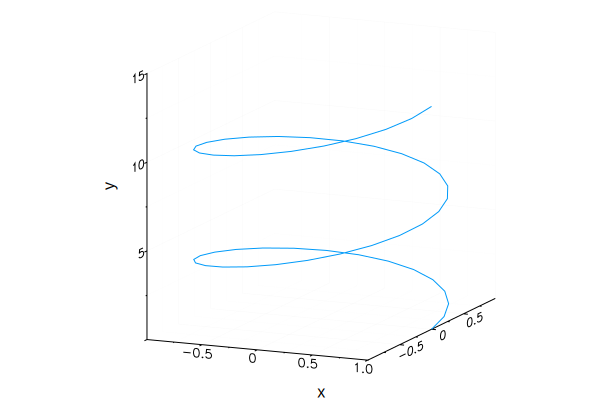

In [1]:
using ODE, Plots, GenericSVD     # load some packages 
gr();                            # set plotting backend
t = linspace(0,4π)
x,y,z = cos.(t), sin.(t), t
plot(x, y, z, l=:path3d, xlab="x", ylab="y", zlab="z", label="")